In [19]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
from time import process_time
from uszipcode import SearchEngine
import json
import folium
from folium.plugins import HeatMapWithTime
from uszipcode import SearchEngine
import json
search = SearchEngine(simple_zipcode=True)
import os.path
from os import path
from IPython.display import display, HTML
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [20]:
def clean_df(df):
    df = df.dropna(subset=['DRIVER_START_MONTH','ZIP'])
    df=df[df['NUMBER_OF_TRIPS']!=0]
    df['NUMBER_OF_TRIPS'] = df['NUMBER_OF_TRIPS'].fillna(1500)
    
    df['ZIP'] = df['ZIP'].apply(lambda x: pd.to_numeric(x, errors='coerce')).fillna(0)
    df['ZIP']=df['ZIP'].astype(int)
    df = df.loc[ (df['ZIP']>59999)&(df['ZIP']<=69999)]
    
    df['Rep_Month']= pd.to_datetime(df['MONTH_REPORTED'], format='%Y-%m')
    df['Start_Month']= pd.to_datetime(df['DRIVER_START_MONTH'], format='%Y-%m')
    df = df.drop(columns=['MONTH_REPORTED','DRIVER_START_MONTH'])
    
    df['Days_Driving'] = pd.to_datetime(df['Rep_Month']).dt.date - pd.to_datetime(df['Start_Month']).dt.date
    df['Months_Driving'] = ((df['Days_Driving'].dt.days)/30).astype(int)
    df['Days_Driving'] = df['Days_Driving'].dt.days
    df['Start_Year']= df['Start_Month'].dt.year
    df['Rep_Year']= df['Rep_Month'].dt.year
    df['Years_Driving'] = df['Rep_Year']-df['Start_Year']

    df= df.reset_index(drop=True)
    return df
    

In [21]:
def get_lan_lng(df):
    lat =[]
    lng = []
    for i in range(0,len(df)):
        zip_info = search.by_zipcode(df['ZIP'][i])
        lat.append(json.loads(zip_info.to_json())['lat'])
        lng.append(json.loads(zip_info.to_json())['lng'])
        if ((i%250000)==0):
            print ('Processed', i, 'rows')
    df['Latitude'] = lat
    df['Longitude'] = lng
    df = df.dropna(subset=['Latitude', 'Longitude'])
    df = df.reset_index()
    return df



def haversine_np(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    distance = 3958.8 * c
    return distance



In [22]:
def load_file(filename,sep=None):
    df = pd.read_csv(filename, low_memory=False,sep=sep)
    return df

def process_df(df, low_trips=True):
    df = df.drop(columns=['index'])
    df=df.loc[df['Distance']<50]
    df =df.loc[df['Start_Year']>2012]
    df = df.loc[df['Days_Driving']>0]
    
    df['Months_Driving'] = df['Months_Driving'] + 1
    df['Trips_per_Month']  = df['NUMBER_OF_TRIPS'] /df['Months_Driving'] 
    df["Years_Driving"] = df["Months_Driving"]/12
    
    df['Trips_per_Year']  = df['NUMBER_OF_TRIPS'] /df['Years_Driving']
    df=df.loc[df['Years_Driving']<=1]
    if low_trips:
        df=df.loc[df['NUMBER_OF_TRIPS']<1000]
    else:
        df=df.loc[df['NUMBER_OF_TRIPS']>1000]
    df = df.reset_index(drop=True)
    return df

In [23]:
fpath = 'C:/Machine Learning/drivers_proc.csv'
if path.exists(fpath):
    drivers_prep = process_df(load_file(fpath,sep='\t'))
    display(drivers_prep.head())
else:
    drivers = clean_df(load_file('C:/Machine Learning/TNP_Drivers.csv'))
    drivers = get_lan_lng(drivers)
    drivers['Distance_from_CC'] = haversine_np( -87.6298,41.8781,drivers['Longitude'],drivers['Latitude'])

,CITY,STATE,ZIP,NUMBER_OF_TRIPS,MULTIPLE_TNPS,Rep_Month,Start_Month,Days_Driving,Months_Driving,Start_Year,Rep_Year,Years_Driving,Latitude,Longitude,Distance,Trips_per_Month,Trips_per_Year
0,Chicago,IL,60612,391.0,True,2018-01-01,2017-02-01,334,12,2017,2018,1.000000,41.880,-87.690,3.099734,32.583333,391.0
1,Eilmette,IL,60091,251.0,False,2017-09-01,2017-07-01,62,3,2017,2017,0.250000,42.080,-87.730,14.869203,83.666667,1004.0
2,Chicago,IL,60606,332.0,False,2018-06-01,2018-02-01,120,5,2018,2018,0.416667,41.882,-87.637,0.458044,66.400000,796.8
3,Berwyn,IL,60402,247.0,False,2018-06-01,2018-02-01,120,5,2018,2018,0.416667,41.830,-87.780,8.414130,49.400000,592.8
4,Glen Ellyn,IL,60137,123.0,True,2018-01-01,2017-02-01,334,12,2017,2018,1.000000,41.860,-88.060,22.170122,10.250000,123.0


In [24]:
high_trips_drivers = process_df(load_file(fpath,sep='\t'),low_trips=False)
high_trips_drivers.head()

,CITY,STATE,ZIP,NUMBER_OF_TRIPS,MULTIPLE_TNPS,Rep_Month,Start_Month,Days_Driving,Months_Driving,Start_Year,Rep_Year,Years_Driving,Latitude,Longitude,Distance,Trips_per_Month,Trips_per_Year
0,Skokie,IL,60076,1500.0,True,2016-01-01,2015-03-01,306,11,2015,2016,0.916667,42.030,-87.740,11.925489,136.363636,1636.363636
1,Chicago,IL,60606,1500.0,True,2018-05-01,2017-11-01,181,7,2017,2018,0.583333,41.882,-87.637,0.458044,214.285714,2571.428571
2,Maywood,IL,60153,1500.0,True,2018-02-01,2017-05-01,276,10,2017,2018,0.833333,41.880,-87.840,10.814407,150.000000,1800.000000
3,Chicago,IL,60645,1500.0,True,2017-04-01,2016-10-01,182,7,2016,2017,0.583333,42.010,-87.690,9.624327,214.285714,2571.428571
4,Chicago,IL,60612,1500.0,True,2018-01-01,2017-03-01,306,11,2017,2018,0.916667,41.880,-87.690,3.099734,136.363636,1636.363636


In [27]:
high_trips_summary = high_trips_drivers.groupby(['ZIP'])['NUMBER_OF_TRIPS'].agg(['count']).sort_values(['count'], ascending=False)
high_trips_summary = high_trips_summary.reset_index()
# Converting ZIP to string to match JSON feature in the next cell
high_trips_summary['ZIP'] = high_trips_summary['ZIP'].astype(str)

In [28]:
chic_coor = [41.8781, -87.6298]
json_data = 'il_illinois_zip_codes_geo.min.json'
high_tr_map = folium.Map(location=chic_coor,zoom_start=9)

high_tr_map.choropleth(geo_data=json_data, 
             data=high_trips_summary,
             columns=['ZIP','count'],
             key_on='feature.properties.ZCTA5CE10',
             fill_color='YlGnBu', fill_opacity=0.5, line_opacity=1,
             name='Driver Resident Zip Code Heat Map',
             legend_name="High Trip Driver Residence ZIP Code Heat Map")

high_tr_map.save('./HTML/High Trip Driver Residence ZIP Code Heat Map.html')

In [29]:
zip_summary=drivers_prep.groupby(['ZIP'])['NUMBER_OF_TRIPS'].agg(['count']).sort_values(['count'], ascending=False)
zip_summary['Sum_Trips'] = drivers_prep.groupby(['ZIP'])['NUMBER_OF_TRIPS'].agg(['sum']).sort_values(['sum'])
zip_summary['Avg_Years_Driving'] = drivers_prep.groupby(['ZIP'])['Years_Driving'].agg(['mean']).sort_values(['mean'])
zip_summary['Avg_Trips_PY'] = zip_summary['Sum_Trips']/(zip_summary['count']*zip_summary['Avg_Years_Driving'])
zip_summary = zip_summary.reset_index()
zip_summary['ZIP'] = zip_summary['ZIP'].astype(str)
zip_summary.sort_values(by=['Avg_Trips_PY'], ascending=False).head(10)

,ZIP,count,Sum_Trips,Avg_Years_Driving,Avg_Trips_PY
1,60659,34735,6924189.0,0.467845,426.088643
2,60645,31683,6094140.0,0.473761,406.000822
21,60660,19573,3701548.0,0.471743,400.886057
11,60626,24589,4411081.0,0.465459,385.409940
23,60616,18484,3129315.0,0.448816,377.211480
14,60640,23259,4018976.0,0.459381,376.141323
283,60603,207,31816.0,0.415459,369.953488
193,60611,1973,324597.0,0.450625,365.091761
68,60415,7098,1096684.0,0.442989,348.781088
4,60625,29998,4900261.0,0.470923,346.878157


In [ ]:
sns.lineplot

In [31]:
chic_coor = [41.8781, -87.6298]
json_data = 'il_illinois_zip_codes_geo.min.json'
ZC_map = folium.Map(location=chic_coor,zoom_start=9)

ZC_map.choropleth(geo_data=json_data, 
             data=zip_summary,
             columns=['ZIP','Avg_Trips_PY'],
             key_on='feature.properties.ZCTA5CE10',
             fill_color='YlGnBu', fill_opacity=0.5, line_opacity=1,
             name='Driver Resident Zip Code Heat Map',
             legend_name="Driver Residence ZIP Code Heat Map")

ZC_map.save('./HTML/Overall Trips Per Year_ZC.html')

In [68]:
chic_coor = [41.8781, -87.6298]
def generateBaseMap(default_location=chic_coor, default_zoom_start=8.5):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map

In [69]:
from folium.plugins import HeatMapWithTime
drivers_year_list = []
drivers_prep['count']=1
basemap = generateBaseMap(default_zoom_start=8)
index = drivers_prep.Start_Year.sort_values().unique().tolist()

for Year in drivers_prep.Start_Year.sort_values().unique():
    drivers_year_list.append(drivers_prep.loc[drivers_prep.Start_Year == Year, ['Latitude','Longitude' ,'count']].groupby(['Latitude','Longitude']).sum().reset_index().values.tolist())

HeatMapWithTime(drivers_year_list, radius=4,index=index, gradient={0.1: 'blue', 0.3: 'lime', 0.6: 'orange', 1: 'red'}, 
                min_opacity=0.5, max_opacity=0.95, use_local_extrema=True).add_to(basemap)

basemap.save('HMAP_With_Time_Drivers.html')
basemap

In [70]:
low_tpy_drivers = drivers_prep.loc[drivers_prep['Trips_per_Year']<400]
low_tpy_by_year = low_tpy_drivers.groupby(['Start_Year'])['Distance'].agg(['mean']).sort_values(['mean'], ascending=False)
low_tpy_by_year = low_tpy_by_year.reset_index()
low_tpy_by_year

,Start_Year,mean
0,2019,16.101968
1,2017,15.898853
2,2018,15.723685
3,2016,15.293287
4,2015,14.379945
5,2014,13.216809


In [71]:
high_tpy_drivers = drivers_prep.loc[drivers_prep['Trips_per_Year']>400]
high_tpy_by_year = high_tpy_drivers.groupby(['Start_Year'])['Distance'].agg(['mean']).sort_values(['mean'], ascending=False)
high_tpy_by_year = high_tpy_by_year.reset_index()
high_tpy_by_year

,Start_Year,mean
0,2016,12.624377
1,2017,12.510052
2,2015,12.425511
3,2014,12.399663
4,2018,12.064818
5,2019,11.840732


Text(0.5, 1.0, 'Mean Driver Residence Distance vs Start Year for Low (<400) and High (>400) Trips Per Year\n')

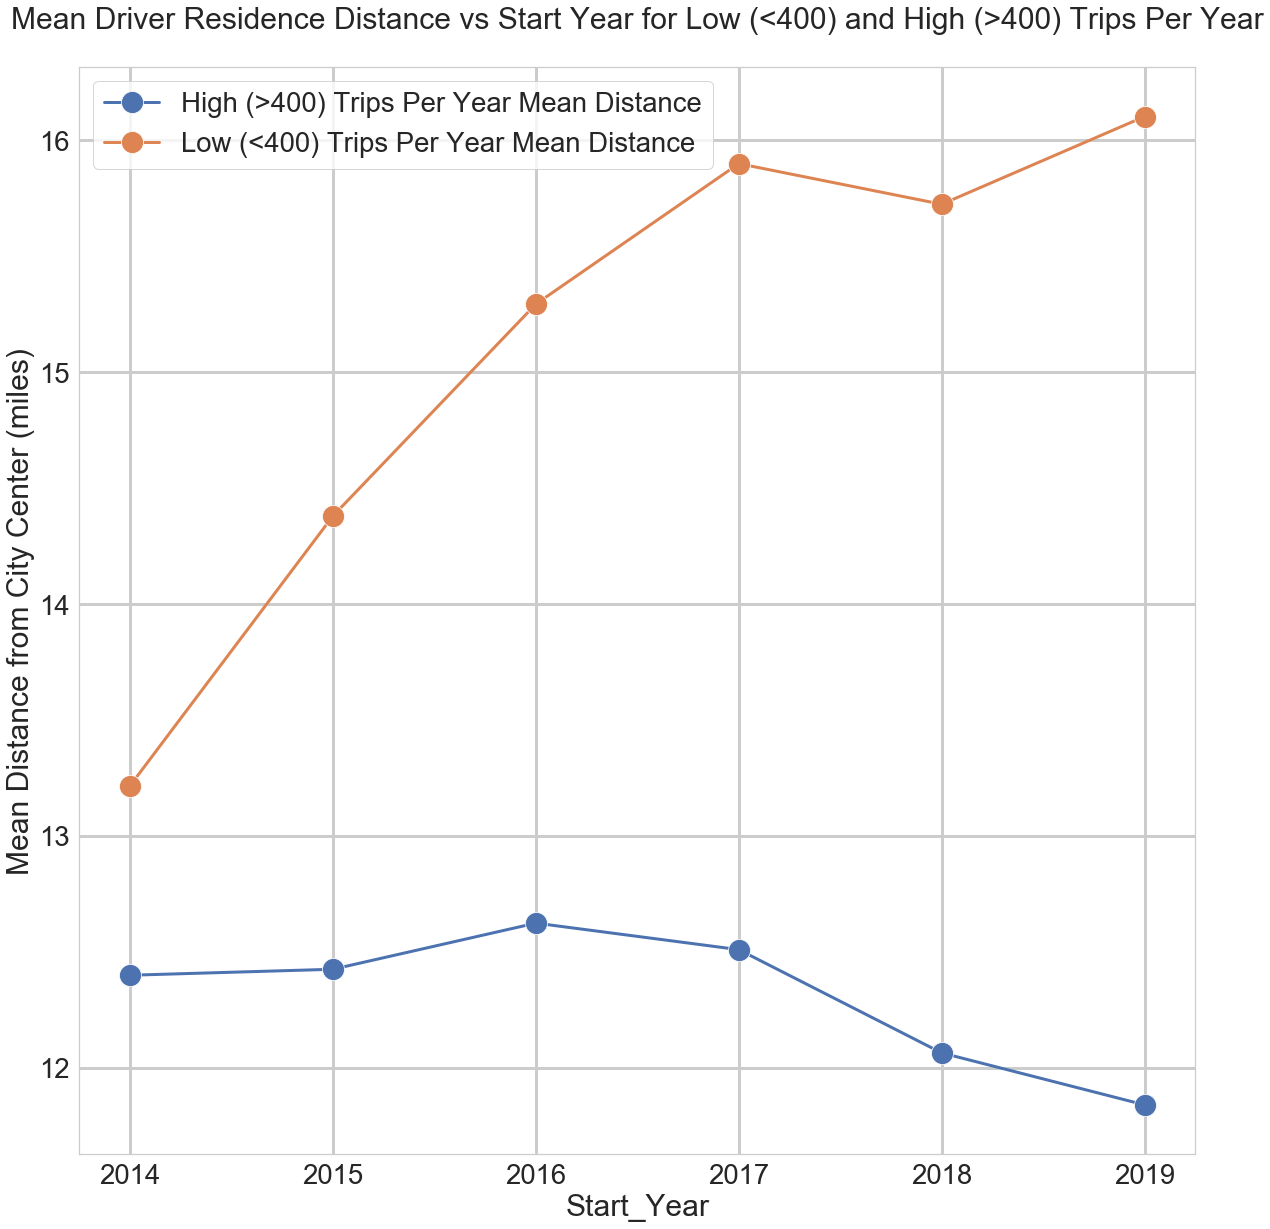

In [72]:
fig = plt.figure(figsize=(20,20))
sns.set(font_scale=2)
sns.set_style('whitegrid')
#sns.set_style("ticks")
sns.set_context("notebook", font_scale=2.5, rc={"lines.linewidth": 3, 'lines.markersize':22,
                                                'grid.linewidth':3, 'grid.color': '#000000' })
sns.lineplot(y='mean', x='Start_Year', data= high_tpy_by_year,marker='o')
sns.lineplot(y='mean', x='Start_Year', data= low_tpy_by_year,marker='o')
plt.ylabel('Mean Distance from City Center (miles)')
plt.legend(['High (>400) Trips Per Year Mean Distance', 'Low (<400) Trips Per Year Mean Distance'])
plt.title('Mean Driver Residence Distance vs Start Year for Low (<400) and High (>400) Trips Per Year\n')


In [73]:
drivers_dist_year= drivers_prep.groupby(['Start_Year','Distance'])['Trips_per_Year'].mean()
drivers_dist_year=drivers_dist_year.reset_index()
drivers_dist_year=drivers_dist_year.rename(columns = {'Distance':'Distance from Chicago Center', 'Trips_per_Year': 'Mean Trips per Year'})

In [74]:
drivers_prep.head()

,CITY,STATE,ZIP,NUMBER_OF_TRIPS,MULTIPLE_TNPS,Rep_Month,Start_Month,Days_Driving,Months_Driving,Start_Year,Rep_Year,Years_Driving,Latitude,Longitude,Distance,Trips_per_Month,Trips_per_Year,count
0,Chicago,IL,60612,391.0,True,2018-01-01,2017-02-01,334,12,2017,2018,1.000000,41.880,-87.690,3.099734,32.583333,391.0,1
1,Eilmette,IL,60091,251.0,False,2017-09-01,2017-07-01,62,3,2017,2017,0.250000,42.080,-87.730,14.869203,83.666667,1004.0,1
2,Chicago,IL,60606,332.0,False,2018-06-01,2018-02-01,120,5,2018,2018,0.416667,41.882,-87.637,0.458044,66.400000,796.8,1
3,Berwyn,IL,60402,247.0,False,2018-06-01,2018-02-01,120,5,2018,2018,0.416667,41.830,-87.780,8.414130,49.400000,592.8,1
4,Glen Ellyn,IL,60137,123.0,True,2018-01-01,2017-02-01,334,12,2017,2018,1.000000,41.860,-88.060,22.170122,10.250000,123.0,1


(0, 50)

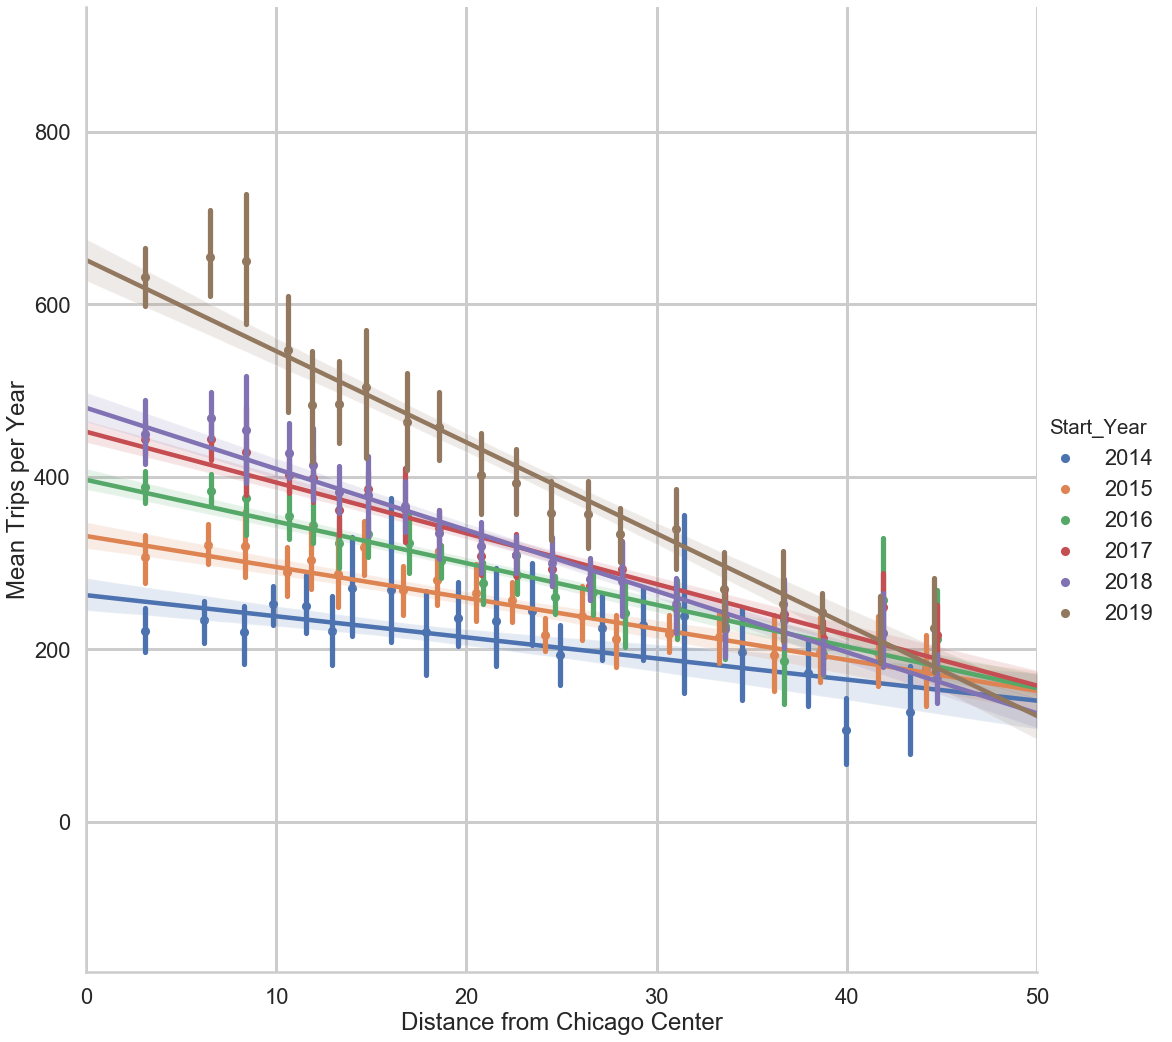

In [75]:
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'},font_scale=3)
sns.set_style("whitegrid")
sns.set_context("poster", rc={'grid.color': 'white', "grid.linewidth": 3})

ax = sns.lmplot(x="Distance from Chicago Center", y="Mean Trips per Year", hue="Start_Year",
                legend_out=True,robust = True, data=drivers_dist_year,x_bins=20,height =15)
plt.xlim(0,50)

In [76]:
drivers_prep.groupby(['Start_Year'])['Trips_per_Month'].mean()

Start_Year
2014    20.507760
2015    24.602946
2016    28.401485
2017    32.041577
2018    33.628502
2019    44.609649
Name: Trips_per_Month, dtype: float64

In [77]:
drivers_prep['Start_Year'].value_counts()

2017    477919
2018    473396
2016    373531
2015    194331
2019    174500
2014     29651
Name: Start_Year, dtype: int64

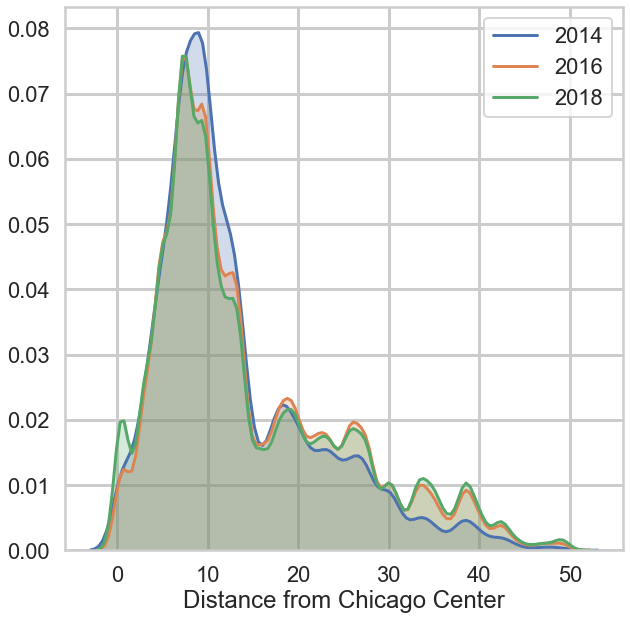

In [78]:
fig = plt.figure(figsize=(10,10))
for year in range(2014,2020,2):
    df=drivers_prep.loc[drivers_prep['Start_Year'] == year]
    x = list(df[df['Start_Year'] == year]['Distance'])
    
    sns.distplot(x, rug=False, hist= False,label=year,norm_hist =True, kde=True,bins=10, kde_kws={"shade": True, "linewidth": 3});

plt.xlabel("Distance from Chicago Center")    
plt.show()

In [79]:
len(drivers_prep.loc[(drivers_prep['Rep_Year'] - drivers_prep['Start_Year']) <=1 ])

1723328

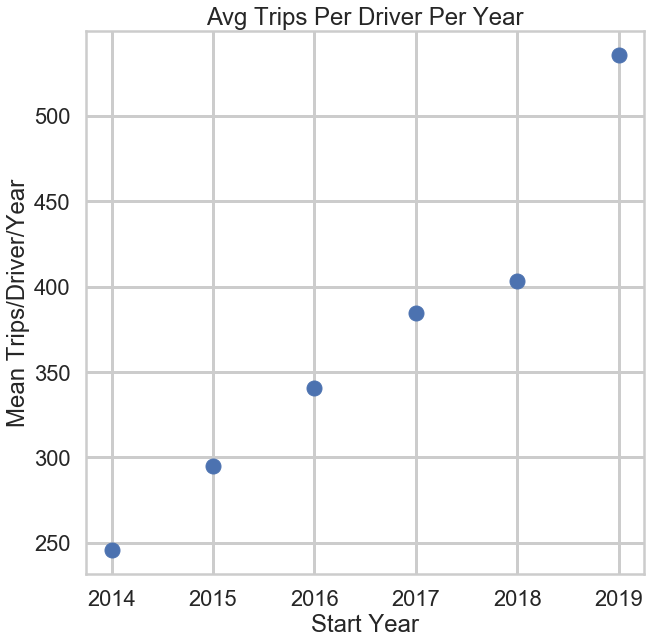

In [80]:

fig = plt.figure(figsize=(10,10))
ax = plt.plot(sorted(drivers_prep['Start_Year'].unique()),(drivers_prep.groupby(['Start_Year'])['Trips_per_Year'].mean()),
              'b.',markersize=30)
plt.xlabel("Start Year")    
plt.ylabel("Mean Trips/Driver/Year")
plt.title('Avg Trips Per Driver Per Year')

plt.show()

In [81]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
lin_reg = LinearRegression()

def linreg(year):
    driver_year=drivers_dist_year.loc[drivers_dist_year['Start_Year'] == year]
    driver_year=driver_year[['Mean Trips per Year','Distance from Chicago Center']]
    
    train_set, test_set = train_test_split(driver_year, test_size=0.2)
    X_train, X_test=train_set['Distance from Chicago Center'].values,test_set['Distance from Chicago Center'].values
    X_train = np.reshape(X_train,(-1,1))
    X_test = np.reshape(X_test,(-1,1))
    y_train, y_test=train_set['Mean Trips per Year'],test_set['Mean Trips per Year']
    
    lin_reg.fit(X_train, y_train)
    predictions = lin_reg.predict(X_test)
    lin_scores = cross_val_score(lin_reg, X_train, y_train, scoring = "neg_mean_squared_error", cv=10)
    lin_cv_rmse = np.sqrt(-lin_scores)
    lin_mse = mean_squared_error(y_test, predictions)
    
    return pd.Series({'Slope': lin_reg.coef_[0], 'Intercept': lin_reg.intercept_, 'CV_RMSE_Mean': lin_cv_rmse.mean(), 'CV_RMSE_Std':lin_cv_rmse.std(), 'Test_RMSE':np.sqrt(lin_mse)} )

lin_reg_years = pd.DataFrame(columns=['Slope', 'Intercept','CV_RMSE_Mean', 'CV_RMSE_Std', 'Test_RMSE'])
for year in drivers_prep.Start_Year.sort_values().unique():
    lin_reg_years.loc[year] = linreg(year)
lin_reg_years

,Slope,Intercept,CV_RMSE_Mean,CV_RMSE_Std,Test_RMSE
2014,-2.078546,259.600853,93.509005,16.921057,101.725711
2015,-3.629891,334.512556,66.552929,9.674512,61.872723
2016,-4.735184,399.959195,65.495439,17.580314,84.959529
2017,-5.946882,455.728778,60.255175,8.002281,64.562220
2018,-6.900940,475.879178,67.609080,10.644397,69.248457
2019,-10.538298,652.916639,103.165458,19.392651,100.310366


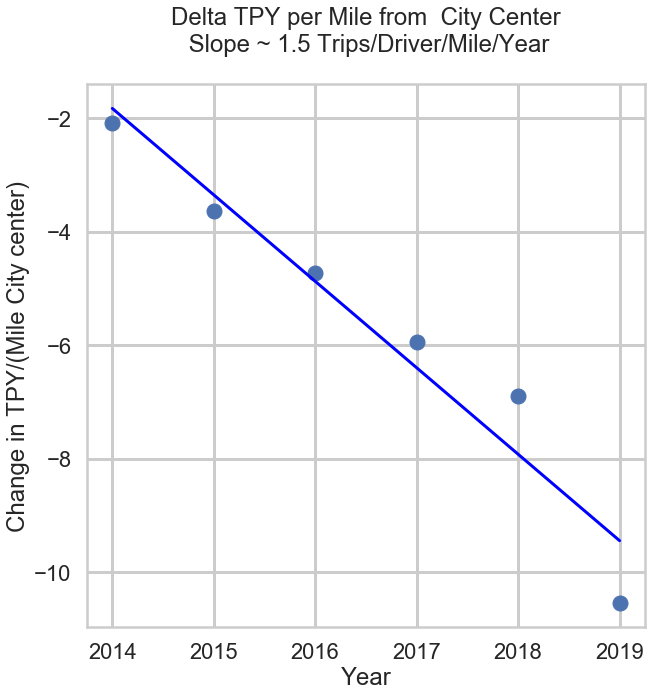

In [90]:
lin_reg_year = lin_reg_years.loc[2013:]
X=(lin_reg_year.index).values
Y=(lin_reg_year['Slope']).values

# Transposing X
x = X.reshape(len(X),1)
# Linear Fit
linreg = LinearRegression()
linreg.fit(x,Y)

fig = plt.figure(figsize=(10,10))
plt.plot(x,Y,'b.',markersize=30)
plt.plot(x, linreg.predict(x), color='blue', linewidth=3)
plt.xlabel(xlabel = 'Year')
plt.ylabel(ylabel = 'Change in TPY/(Mile City center)')
plt.title('Delta TPY per Mile from  City Center\n Slope ~ 1.5 Trips/Driver/Mile/Year\n')
plt.show()


In [84]:
linreg.coef_

array([-1.52353166])